## FCNN linear regression

Выполнила: Галиуллина Алина Ринатовна
<br>
Тема работы: многослойный перцептрон
<br>
Основные комментарии по существу задачи будут в ячейках "Markdown". Примечания по коду будут закомментированы в ячейках самого кода

In [1]:
# # Импортируем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

### ШАГ 0. Постановка задачи.

<b>Задача </b>: построить модель регрессии для предсказания.

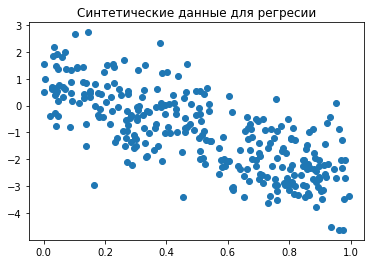

In [2]:
np.random.seed(21)

# Воспользуемся синтетическими данными
w0_true, w1_true = 1, -4

X = np.random.rand(300,1) 
y = w0_true + w1_true * X + np.random.randn(300, 1)

plt.scatter(X, y)
plt.title('Синтетические данные для регресии')
plt.show()

### ШАГ 1. Реализация архитектуры для решения задачи регрессии

In [3]:
class FullyConnectedNetwork:
    __REGULARIZATION_GRAD = {None: lambda _w: 0, "l1": lambda _w: np.sign(_w), "l2": lambda _w: 2*_w}
    __REGULARIZATION_FUNC = {None: lambda _w: 0, "l1": lambda _w: np.abs(_w), "l2": lambda _w: _w ** 2}
    __LOSS = 0
    
    # создание нейронной сети: alpha — скорость обучения (шаг градиентного спуска),
    # reg_type — тип регуляризации (если есть), lambda — параметр регуляризации; слои будут храниться в списке layers
    def __init__(self, alpha=0.01, reg_type=None, lambda_=0):
        self.__layers = list()
        self.__alpha = alpha
        self.__reg_type = reg_type
        self.__lambda = lambda_
        

    # метод, позволяющий добавить новый слой: указываем правильные размеры слоя, название функции активации, class_number — количество классов в случае использования Sotmax'а на последнем слое, параметр a — параметр LeakyReLU
    def add_layer(self, size: tuple, activation_func: str, a=0,loss=''):
        if not self.__layers or self.__layers[-1].size[1] == size[0]:
            self.__layers.append(FullyConnectedLayer(size, activation_func, a,loss))
        else:
            raise Exception("Wrong size of the layer!")

    def change_alpha(self, alpha):
        self.__alpha = alpha

    def get_loss(self):
        return FullyConnectedNetwork.__LOSS

    
    def predict(self, data):
        current_output = data
        for layer in self.__layers[:-1]:
            current_output, _ = layer.forward(current_output, None)
        layer_weights, layer_biases = self.__layers[-1].get_weights()
        return np.matmul(current_output, layer_weights) - layer_biases


    def fit(self, data, answers):
        # выход входного слоя совпадает с фичами входных данных
        layer_outputs = [data]
        current_output = layer_outputs[0]
        grads = []
        # forward pass и вычисление градиентов функций активации
        for layer in self.__layers:
            current_output, gradient = layer.forward(current_output, answers)
            layer_outputs.append(current_output)
            grads.append(gradient)
        # для вычисления градиентов по правилу цепочки, удобно развернуть массив
        grads = grads[::-1]
        # для градиента параметров самого первого слоя, умножаем на «производную» независимой переменной
        grads.append(1)
        current_gradient = grads[0]
        FullyConnectedNetwork.__LOSS = layer_outputs[-1]
        for i, layer in enumerate(self.__layers[::-1]):
            layer_weights, layer_biases = layer.get_weights()
            FullyConnectedNetwork.__LOSS += self.__lambda * (np.sum(FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_weights) + FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_biases)))
            # вычисление градиента параметров W слоя layer
            d_weights = np.matmul(layer_outputs[-2 - i].T, current_gradient)
            # вычисление градиента параметров db слоя layer
            d_bias = -np.matmul(np.ones(layer_outputs[-2 - i].shape[0]), current_gradient) / layer_outputs[-2 - i].shape[0]
            # выполнение шага градиентного спуска
            layer.update_weights(self.__alpha * (d_weights + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_weights)) , self.__alpha * (d_bias + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_biases)))
            # правило цепочки
            current_gradient = np.matmul(current_gradient, layer_weights.T) * grads[i + 1]

# класс, отвечающий за слой в нейронной сети
class FullyConnectedLayer:
    # мы предполагаем, что реализованы следующие функции активации, на последнем слое возможно решение задачи классификации с Softmax
    __ACTIVATION_FUNCTIONS = {'ReLU': {'func': lambda a, x: np.maximum(x, 0), 'derivative': lambda a, x: np.where(x >= 0, 1, 0)},
                              'LReLU': {'func': lambda a, x: np.where(x >= 0, x, a*x), 'derivative': lambda a, x: np.where(x >= 0, 1, a)},
                              'None': {'func': lambda a, x: x, 'derivative': lambda a, x: 1},
                              'Sigmoid': {'func': lambda a, x: np.exp(x) / (1 + np.exp(x)), 'derivative': lambda a, x: np.exp(x) / (1 + np.exp(x)) ** 2},
                              }
    
    # создание нового слоя: задание размеров слоя, случайная (равномерная на [-1/2, 1/2]) инициализация весов, запоминание функции активации, фиксация количества классов в случае решения задачи классификации
    def __init__(self, size: tuple, activation_func: str, a=0, loss=''):
        self.size = size
        self.__weights = np.random.random((size[0], size[1])) - 0.5
        self.__bias = np.random.random((1, size[1])) - 0.5
        self.__a = a
        if activation_func in FullyConnectedLayer.__ACTIVATION_FUNCTIONS.keys():
            self.__activation_func = activation_func
        else:
            raise Exception("No such activation function!")
        if activation_func == 'None':
            self.__loss = loss

    # метод, возвращающий значения весов: веса и смещения
    def get_weights(self):
        return self.__weights, self.__bias

    def get_activation_func(self):
        return self.__activation_func

    # метод, модифицирующий веса после градиентного шага
    def update_weights(self, d_weights, d_biases):
        self.__weights -= d_weights
        self.__bias -= d_biases

    # метод, возвращающий градиент
    def __get_grad(self, data, answers):
        return FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['derivative'](self.__a, data)

    def __mse_loss_grad(self, data, answers):
        activation =  np.mean((data - answers.reshape(-1,1)) ** 2)
        gradient = 2 * (data - answers.reshape(-1,1)) / len(answers)
        return activation, gradient

    def __mae_loss_grad(self, data, answers):
        activation =  np.mean(np.abs(data - answers.reshape(-1,1)))
        gradient = np.sign(data - answers.reshape(-1,1)) / len(answers)
        return activation, gradient


    # проход по слою с вычислением градиента функции активации на текущей итерации и текущем наборе данных, для последнего слоя нет нужды вычислять значение, если только не хочется узнать что-то про функцию потерь
    def forward(self, data, answers):
        if self.__activation_func =="None":
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            if self.__loss == 'MAE':
                activation, gradient = self.__mae_loss_grad(matrix_pass, answers)
            elif self.__loss == 'MSE':
                activation, gradient = self.__mse_loss_grad(matrix_pass, answers)
        else:
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            activation = FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['func'](self.__a, matrix_pass)
            gradient = self.__get_grad(matrix_pass, answers)
        return activation, gradient

In [4]:
# @title MSE
NN = FullyConnectedNetwork(alpha=0.11, reg_type='l2', lambda_=0.002)
loss = []
NN.add_layer(size=(1, 48), activation_func='ReLU')
NN.add_layer((48, 1), activation_func='None', loss='MSE')
alpha = 0.1
for ep in range(1000):
    NN.fit(X, y)
    loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        alpha = alpha / 10
        NN.change_alpha(alpha)
        print(f'MSE={mean_squared_error(y, NN.predict(X))}')

MSE=0.9779212486669769
MSE=0.9776170583672694
MSE=0.9776075481871768
MSE=0.977606616875419
MSE=0.977606524050456
MSE=0.9776065147600199
MSE=0.9776065138310199
MSE=0.9776065137379878
MSE=0.9776065137286984
MSE=0.977606513727769


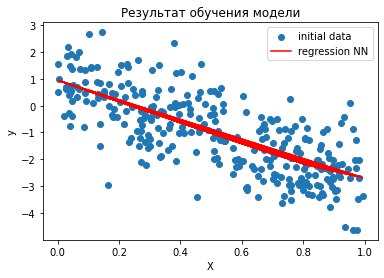

In [5]:
# Визиализируем результаты.
plt.scatter(X, y, label='initial data')
plt.plot(X, NN.predict(X), color = 'red', label='regression NN')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Результат обучения модели')
plt.show()

### Выводы

В работе была выполена реализация полносвязной нейронной сети для решения задачи регрессии.